In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import corner

from cmcrameri import cm
from matplotlib.lines import Line2D
from matplotlib.colors import to_hex, to_rgba
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from pqcd.utils import (
    rcparams,
    to_nucleons_per_cubic_femtometre,
    to_GeV_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
)
plt.rcParams.update(rcparams)

In [2]:
# GP0 quantities for reference

# Collated EOSs
collated_eos_gp0 = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default.csv',
    index_col='eos'
)
collated_eos_gp0_with_ntov = pd.read_csv(
    '../data/eos-draws-default/collated_np_all_post.csv',
    index_col='eos'
)
collated_eos_gp0['ntov'] = collated_eos_gp0_with_ntov['rhoc(M@Mmax)']

# Quantities at nTOV
ntov_gp0 = to_nucleons_per_cubic_femtometre(collated_eos_gp0['ntov'])
ptov_gp0 = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/pressure_ntov.dat'
)
etov_gp0 = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat'
)

# Weights
astro_weights_gp0 = np.exp(
    collated_eos_gp0.logweight_total - collated_eos_gp0.logweight_total.max()
).values
ntov_max_weights_gp0 = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'
)
ntov_marg_weights_gp0 = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat'
)

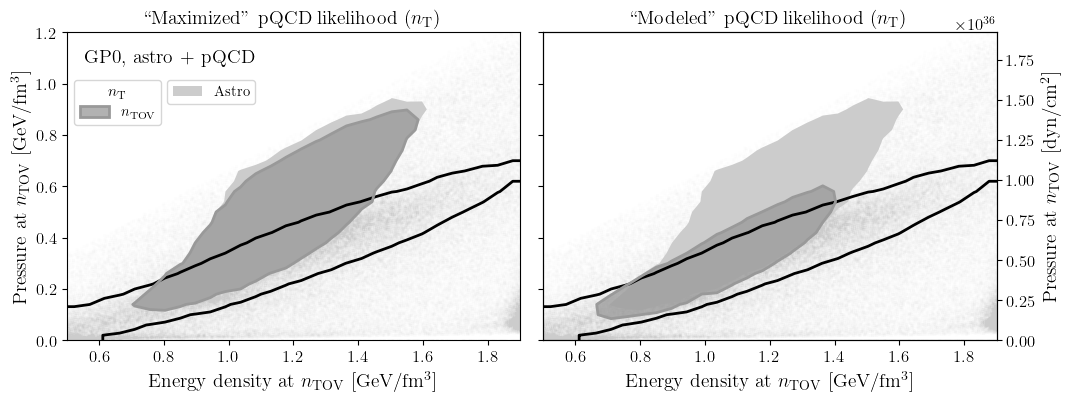

In [3]:
prior_c = '#cccccc'
ntov_c = '#999999'
ntov_fill_alpha = 0.75
ntov_lw = 2

eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

hist_kwargs = dict(
    bins=30,
    levels=[0.9],
    smooth=0.5,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    range=[eps_lim, p_lim]
)

titles = [
    '``Maximized" pQCD likelihood ($n_\mathrm{T}$)', 
    '``Modeled" pQCD likelihood ($n_\mathrm{T}$)'
]

ntov_weights = [ntov_max_weights_gp0, ntov_marg_weights_gp0]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)
axs[0].text(0.04, 0.9, 'GP0, astro + pQCD', transform=axs[0].transAxes)

for i, ax in enumerate(axs):

    ax.set_title(titles[i])

    # Prior
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=astro_weights_gp0, 
        color=prior_c,
        plot_datapoints=True,
        data_kwargs={'alpha': 0.02},
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'colors': prior_c, 'antialiased': True},
        **hist_kwargs
    )

    # pQCD only
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=ntov_marg_weights_gp0, 
        color='k',
        plot_datapoints=False,
        contour_kwargs={'linewidths': 2},
        contourf_kwargs={
            'colors': ntov_c, 'antialiased': True, 'alpha': 0
        },
        **hist_kwargs
    )
    
    # nTOV posterior
    weights = ntov_weights[i]
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=astro_weights_gp0*weights, 
        color=ntov_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': ntov_lw},
        contourf_kwargs={
            'colors': ntov_c, 'antialiased': True, 'alpha': ntov_fill_alpha
        },
        **hist_kwargs
    )

# ---

contours = [
    mpatches.Patch(
        edgecolor=ntov_c, 
        linewidth=ntov_lw, 
        facecolor=list(to_rgba(ntov_c))[:3] + [ntov_fill_alpha]
    )
]
contour_labels = ['$n_\mathrm{TOV}$']

filled_contours = [
    mpatches.Patch(color=prior_c, linewidth=0),
]
filled_contour_labels = ['Astro']

l1 = axs[0].legend(
    contours,
    contour_labels,
    loc='upper left',
    ncol=1,
    bbox_to_anchor=(0, 0.87),
    title='$n_\mathrm{T}$',
    fontsize=10.5,
    title_fontsize=11
)
axs[0].add_artist(l1)

l2 = axs[0].legend(
    filled_contours,
    filled_contour_labels,
    loc='upper left',
    bbox_to_anchor=(0.205, 0.87),
    fontsize=10.5,
)
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]');

In [4]:
gp1_collated_eos = pd.read_csv(
    '../data/eos-draws-modified/gp1/eos-draws-modified-gp1.csv',
    index_col='eos'
)

gp2_collated_eos = pd.read_csv(
    '../data/eos-draws-modified/gp2/eos-draws-modified-gp2.csv',
    index_col='eos'
)

In [5]:
gp1_astro_weights = np.exp(
    gp1_collated_eos.logweight_total - gp1_collated_eos.logweight_total.max()
).values

gp2_astro_weights = np.exp(
    gp2_collated_eos.logweight_total - gp2_collated_eos.logweight_total.max()
).values

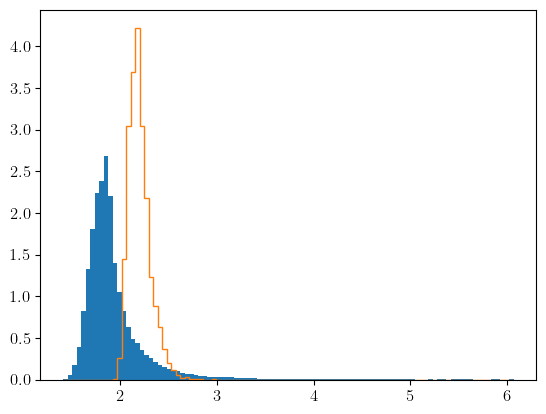

In [6]:
fig, ax = plt.subplots()
ax.hist(gp1_collated_eos['Mmax'], bins=100, density=True)
ax.hist(
    gp1_collated_eos['Mmax'], 
    weights=gp1_astro_weights, 
    histtype='step',
    bins=100, 
    density=True
);

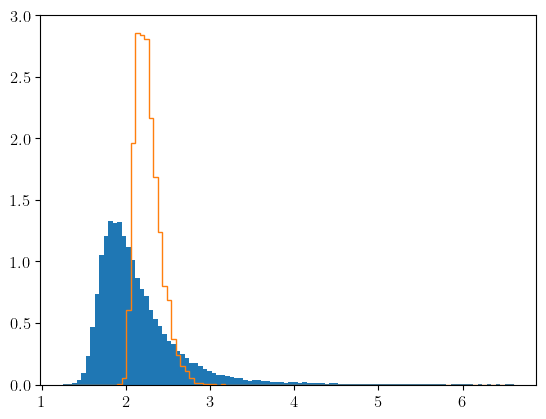

In [7]:
fig, ax = plt.subplots()
ax.hist(gp2_collated_eos['Mmax'], bins=100, density=True)
ax.hist(
    gp2_collated_eos['Mmax'], 
    weights=gp2_astro_weights, 
    histtype='step',
    bins=100, 
    density=True
);

In [8]:
ntov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/density_ntov.dat'
)

ptov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/pressure_ntov.dat'
)

etov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/energy_density_ntov.dat'
)

ntov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/density_ntov.dat'
)

ptov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/pressure_ntov.dat'
)

etov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/energy_density_ntov.dat'
)

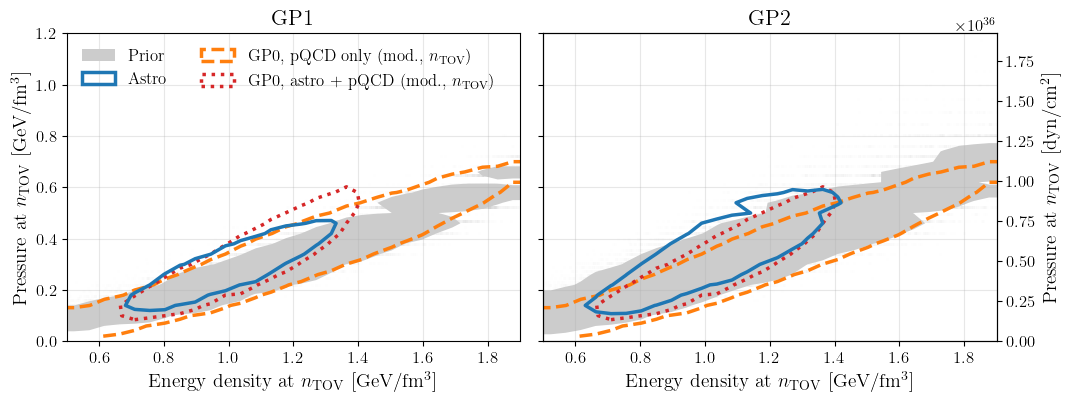

In [31]:
prior_c = '#cccccc'
gp0_pqcd_c = to_hex('C1')
gp0_pqcd_ls = '--'

astro_c = to_hex('C0')
gp0_astro_pqcd_c = to_hex('C3')
gp0_astro_pqcd_ls = ':'

lw = 2.5

eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

hist_kwargs = dict(
    bins=30,
    levels=[0.9],
    smooth=0.5,
    fill_contours=True,
    plot_density=False,
    no_fill_contours=True,
    range=[eps_lim, p_lim]
)

titles = [
    'GP1', 
    'GP2'
]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)

for i, ax in enumerate(axs):
    ax.grid(alpha=0.3)
    ax.set_title(titles[i], fontsize=16)

# GP1 prior
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=axs[0],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# GP2 prior
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[1],
    color=prior_c,
    plot_datapoints=True,
    data_kwargs={'alpha': 0.02},
    contour_kwargs={'linewidths': 0},
    contourf_kwargs={'colors': prior_c, 'antialiased': True},
    **hist_kwargs
)

# GP0 pQCD-only
for ax in axs:
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=ntov_marg_weights_gp0, 
        color=gp0_pqcd_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': lw, 'linestyles': gp0_pqcd_ls},
        contourf_kwargs={'alpha': 0},
        **hist_kwargs
    )

# GP0 astro+pQCD
for ax in axs:
    corner.hist2d(
        etov_gp0, 
        ptov_gp0, 
        ax=ax,
        weights=ntov_marg_weights_gp0*astro_weights_gp0, 
        color=gp0_astro_pqcd_c,
        plot_datapoints=False,
        contour_kwargs={'linewidths': lw, 'linestyles': gp0_astro_pqcd_ls},
        contourf_kwargs={'alpha': 0},
        **hist_kwargs
    )

# GP1 astro
corner.hist2d(
    etov_gp1, 
    ptov_gp1, 
    ax=axs[0],
    weights=gp1_astro_weights, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# GP2 astro
corner.hist2d(
    etov_gp2, 
    ptov_gp2, 
    ax=axs[1],
    weights=gp2_astro_weights, 
    color=astro_c,
    plot_datapoints=False,
    contour_kwargs={'linewidths': lw},
    contourf_kwargs={'alpha': 0},
    **hist_kwargs
)

# ---

handles = [
    mpatches.Patch(color=prior_c, linewidth=0),
    mpatches.Patch(edgecolor=astro_c, fill=False, linewidth=lw),
    mpatches.Patch(
        edgecolor=gp0_pqcd_c, fill=False, linewidth=lw, linestyle=gp0_pqcd_ls
    ),
    mpatches.Patch(
        edgecolor=gp0_astro_pqcd_c, 
        fill=False, 
        linewidth=lw, 
        linestyle=gp0_astro_pqcd_ls
    )
]
labels = [
    'Prior',
    'Astro',
    'GP0, pQCD only (mod., $n_\mathrm{TOV}$)',
    'GP0, astro + pQCD (mod., $n_\mathrm{TOV}$)'
]
axs[0].legend(
    handles,
    labels,
    loc='upper left',
    frameon=False,
    ncol=2
)

# ---
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/paper/p_eps_tov_gp1_gp2.pdf', bbox_inches='tight')